# MPS using the deesse wrapper - simulations with connectivity data

## Main points addressed:
- how to set hard data with connectivity data
- how to set connectivity constraints

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=10, micro=6, releaselevel='final', serial=0)
geone version: 1.1.5


## Training image (TI)
Read the training image.

In [3]:
ti = gn.img.readImageGslib('ti.gslib')

Plot the image (using the function `geone.imgplot.drawImage2D`).

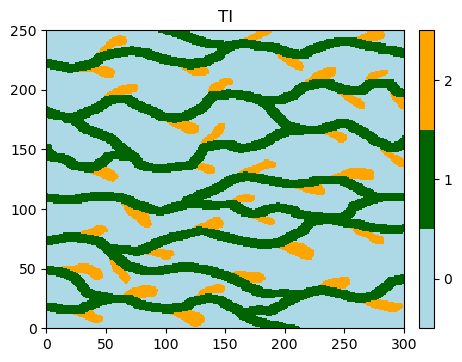

In [4]:
col = ['lightblue', 'darkgreen', 'orange']

plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, categ=True, categCol=col, title='TI')
plt.show()

## Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [5]:
nx, ny, nz = 100, 100, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

## Hard data and connectivity data
A hard data point is defined by:
- its spatial coordinates (`x`, `y`, `z`) in the simulation grid,
- the value of the simulated variable, whose the name (`code` in the example below) identical to the name given by `varname` in the class `geone.deesseinterface.DeesseInput` (input for deesse),
- a connected component (geobody) label, whose the name (`geobody_label` in the example below) identical to the name given by `varname` in the class `geone.deesseinterface.Connectivity` describing the connectivity constraints.

Points with the same *positive* connected component label means that they should be connected in the output realizations. A negative or zero label means no connectivity constraints on that point.

In [6]:
npt = 5 # number of points
nv = 5   # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'code', 'geobody_label'] # list of variable names
v = np.array([
    [ 10.5,  40.5, 0.5,  1, 1], # x, y, z, code, geobody_label: 1st point
    [ 50.5,  35.5, 0.5,  1, 1], # 2nd point: should be connected to the 1st point
    [ 90.5,  48.5, 0.5,  1, 1], # 3rd point: should be connected to the 1st and 2nd points
    [ 75.5,  50.5, 0.5,  0, 0], # no connectivity constraint on that point
    [ 20.5,  80.5, 0.5,  2, 0], # no connectivity constraint on that point
    ]).T # variable values: (nv, npt)-array
hd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

### Specifiy the connectivity constraints (class `geone.deesseinterface.Connectivity`)
The way how to deal with the connectivity data is described by the class `geone.deesseinterface.Connectivity`, whose the parameters (keyword arguments) are:
- `connectivityConstraintUsage`: integer with the following meaning:
    - 0: no connectivity constraint
    - 1: paste connecting paths before simulation by successively binding the cells to be connected in a random order
    - 2: paste connecting paths before simulation by successively binding the cells to be connected beginning with the pair of cells with the smallest distance and then the remaining cells in increasing order according to their distance to the set of cells already connected (the distance between two cells is defined as the length (in number of cells) of the minimal path binding the two nodes in an homogeneous connected medium according to the type of connectivity `connectivityType`)
    - 3: check connectivity pattern during simulation (*not working properly...*)
- `connectivityType`: a character string indicating which type of connection is used:
    - `connect_face`: connection through the *faces* of the cells ("6-neighbors connection")
    - `connect_face_edge`: connection through the *faces* or *edges* of the cells ("18-neighbors connection")
    - `connect_face_edge_corner`: connection through the *faces* or *edges* or *corner* (*vertices*) of the cells ("26-neighbors connection")
- `nclass` and `classInterval`: define the number of classes, and for each class the ensemble of values that can be connected together as a (union of) interval(s) (these parameters are defined as for probability constraints, see the corresponding example)
- `varname`: the name of the connected component label, should be present in a conditioning data set (`geobody_label` in this example)
- `tiAsRefFlag`: boolean (used if `connectivityConstraintUsage=1 or 2`) indicating that the paths pasted in the simulation grid are borrowed from the TI (`True`) or from the image given by `refConnectivityImage` (`False`)
- `refConnectivityImage` and `refConnectivityVarIndex` : image (class `geone.img.Img`) and index of the variable used (integer) from which the paths pasted in the simulation grid are borrowed (if `connectivityConstraintUsage=1 or 2` and `tiAsRefFlag=False`)
- `deactivationDistance` and `threshold`: parameters for `connectivityConstraintUsage=3`

In [7]:
# Define connectivity constraints
co = gn.deesseinterface.Connectivity(
    connectivityConstraintUsage=2,
    connectivityType='connect_face_edge_corner',
    nclass=3,
    classInterval=[[-0.5, 0.5], [0.5, 1.5], [1.5, 2.5]],
    varname='geobody_label',
    tiAsRefFlag=True
)

### Fill the input structure for deesse and launch deesse

In [8]:
nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    dataPointSet=hd,          # set hard data and connectivity data
    connectivity=co,          # set connectivity constraint
    outputPathIndexFlag=True, # get simulation path in output (to plot pasted paths)
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete


### Retrieve the results, do some statistics, and display

In [9]:
# Retrieve the results
sim = deesse_output['sim']
path = deesse_output['path']

# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageCategProp(all_sim, [0, 1, 2]) # do statistics (pixel-wise proportion) 

# Add 10 to cells coming from hard data set or from a pasted path (simulation path index is nan):
# this trick will allow to highlight these cells...
for i in range(nreal):
    sim[i].val = sim[i].val + 10 * np.isnan(path[i].val)

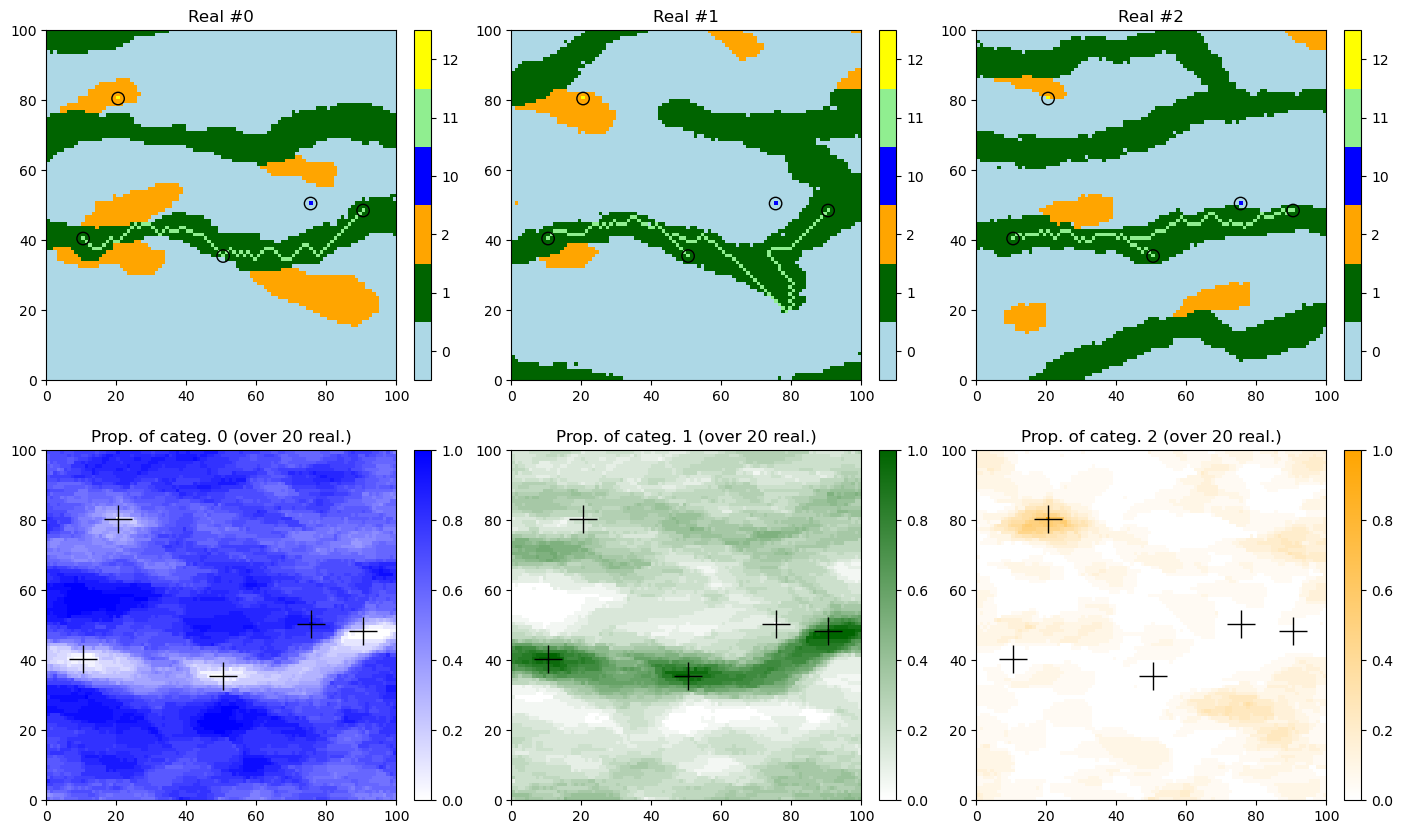

In [10]:
# Display
new_col=['blue', 'lightgreen', 'yellow'] # colors for the "new" facies: 10, 11, 12

prop_col=['blue', 'darkgreen', 'orange'] # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

plt.subplots(2, 3, figsize=(17,10)) # 2 x 3 sub-plots
# ... the first three realizations
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, 
                           categVal=[0, 1, 2, 10, 11, 12], # category to be displayed
                           categCol=col + new_col,         # colors used (+ for concatenation of lists)
                           title='Real #{}'.format(i))
    plt.scatter(hd.x(), hd.y(), marker='o', s=80, 
                color='none', edgecolors='black', linewidths=1) # add hard data points

for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i],
                           title='Prop. of categ. {} (over {} real.)'.format(i, nreal))
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='black') # add hard data points

plt.show()

In [11]:
# Do statistics on pasted paths
for i in range(nreal):
    path[i].val = 1 * np.isnan(path[i].val)
    
all_path = gn.img.gatherImages(path) # all_path is one image with nreal variables
all_path_stats = gn.img.imageCategProp(all_path, [1]) # do statistics (pixel-wise proportion)

# ...multiply by nreal to get the number of times a cell is in a pasted path (or coming from the hard data set)
all_path_stats.val = nreal*all_path_stats.val 

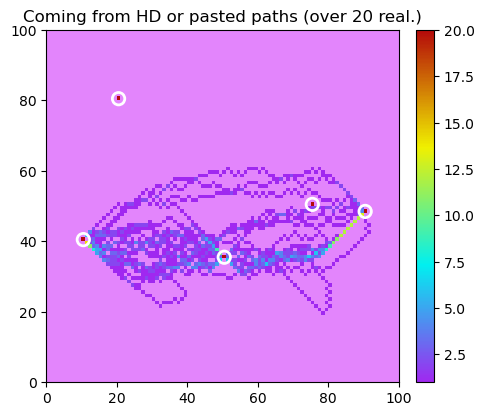

In [12]:
# Display the number of times a cell is in a pasted path (or coming from the hard data set)
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(all_path_stats,
                       cmap=gn.customcolors.cmap1, # color map used (this is the default one)
                       vmin=1, # ... value zero will be displayed with color 'cunder' from gn.customcolors.cmap1
                       title='Coming from HD or pasted paths (over {} real.)'.format(nreal))
plt.scatter(hd.x(), hd.y(), marker='o', s=80, 
            color='none', edgecolors='white', linewidths=2) # add hard data points
plt.show()